In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [4]:
df = pd.read_csv('../../data/smooth_df.csv')

date_column = 'Date'
date_number_column = 'Date Number'
ili_rate_column = 'ILI Rate'
query_columns = [col for col in df.columns if col not in [date_column, date_number_column, ili_rate_column]]

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

print(df.shape)

(6933, 17203)


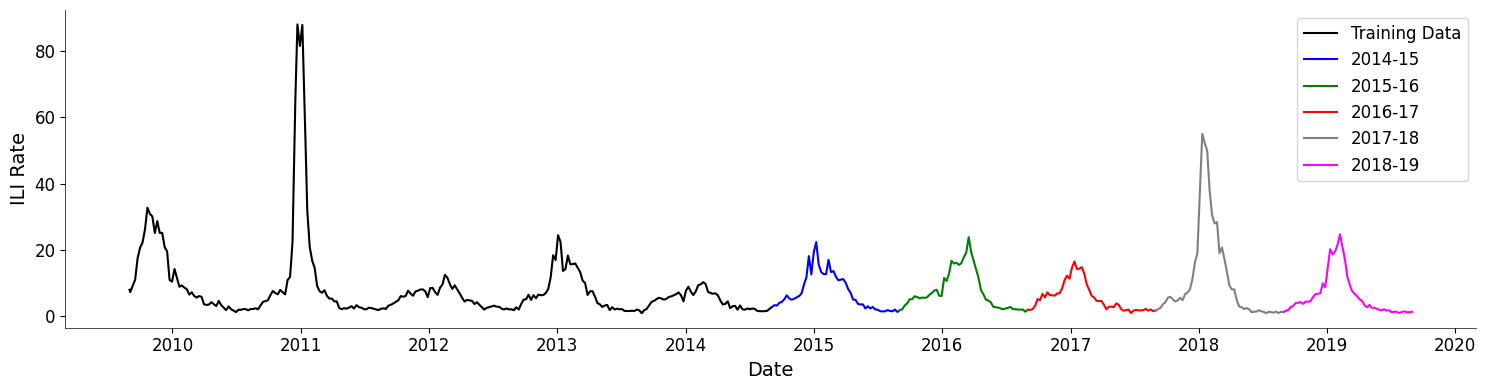

In [6]:
train_start = '2009-09-01'
test_end = '2019-08-31'

final_df = df[(df['Date'] >= train_start) & (df['Date'] <= test_end)]
final_df.set_index('Date', inplace=True)

plt.figure(figsize=(15, 4))

flu_seasons = {
    '2009-10': ('2009-09-01', '2010-08-31'),
    '2010-11': ('2010-09-01', '2011-08-31'),
    '2011-12': ('2011-09-01', '2012-08-31'),
    '2012-13': ('2012-09-01', '2013-08-31'),
    '2013-14': ('2013-09-01', '2014-08-31'),
    '2014-15': ('2014-09-01', '2015-08-31'),
    '2015-16': ('2015-09-01', '2016-08-31'),
    '2016-17': ('2016-09-01', '2017-08-31'),
    '2017-18': ('2017-09-01', '2018-08-31'),
    '2018-19': ('2018-09-01', '2019-08-31'),
}

colors = ['black', 'blue', 'green', 'red', 'grey', 'magenta']

for i, (season, dates) in enumerate(flu_seasons.items()):
    if i < 5:
        label = 'Training Data'
    else:
        label = season
    start, end = dates
    season_df = final_df.loc[start:end]
    plt.plot(season_df.index, season_df['ILI Rate'], linestyle='-', color=colors[max(0, i-4)], label=label if i == 0 or i >= 5 else None)

plt.xlabel('Date', fontsize=14)
plt.ylabel('ILI Rate', fontsize=14)
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)

plt.tight_layout()
plt.savefig("graphs/ili_rate_across_flu_seasons.pdf", format="pdf", bbox_inches='tight')
plt.show()

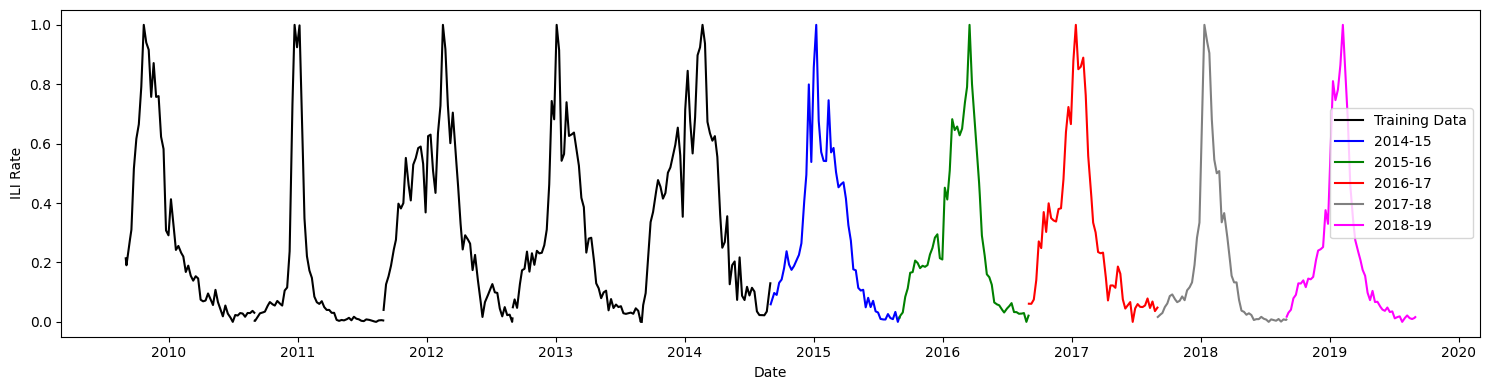

In [8]:
normalised_df = final_df.copy()

for season, dates in flu_seasons.items():
    start, end = dates
    season_df = normalised_df.loc[start:end]
    max_ili_rate = season_df[ili_rate_column].max()
    min_ili_rate = season_df[ili_rate_column].min()
    normalised_df.loc[start:end, ili_rate_column] = (season_df[ili_rate_column] - min_ili_rate) / (max_ili_rate - min_ili_rate)

plt.figure(figsize=(15, 4))

for i, (season, dates) in enumerate(flu_seasons.items()):
    if i < 5:
        label = 'Training Data'
    else:
        label = season
    start, end = dates
    season_df = normalised_df.loc[start:end]
    plt.plot(season_df.index, season_df['ILI Rate'], linestyle='-', color=colors[max(0, i-4)], label=label if i == 0 or i >= 5 else None)

plt.xlabel('Date')
plt.ylabel('ILI Rate')
plt.legend()
plt.tight_layout()
plt.show()

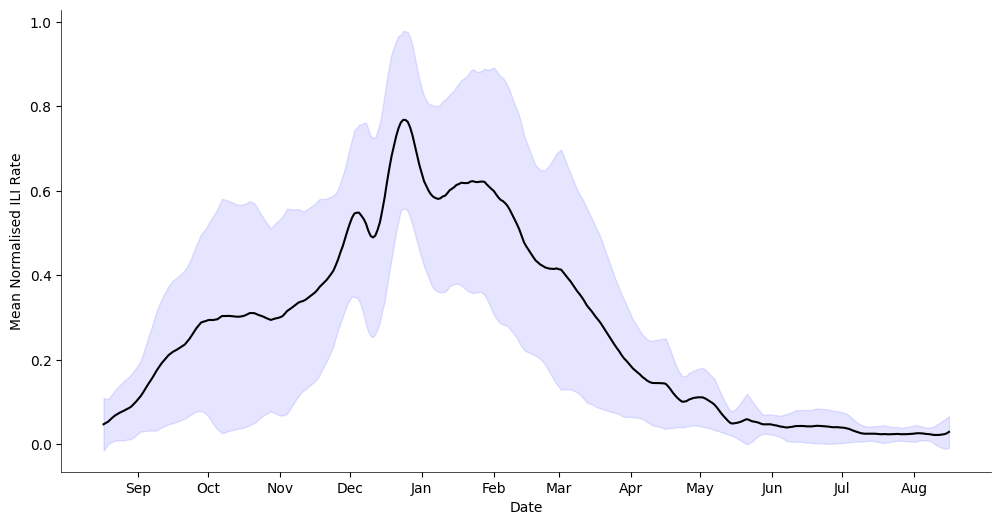

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

normalised_df['MonthDay'] = normalised_df.index.strftime('%m-%d').dropna()

mean_ili_by_month_day = normalised_df.groupby('MonthDay')['ILI Rate'].mean()
std_ili_by_month_day = normalised_df.groupby('MonthDay')['ILI Rate'].std()

index_dates = pd.date_range('1900-09-01', '1901-08-31').strftime('%m-%d')
mean_ili_by_month_day = mean_ili_by_month_day.reindex(index_dates)
std_ili_by_month_day = std_ili_by_month_day.reindex(index_dates)

plt.figure(figsize=(12, 6))

plt.plot(mean_ili_by_month_day.index, mean_ili_by_month_day, linestyle='-', color='black')

plt.fill_between(mean_ili_by_month_day.index, 
                 (mean_ili_by_month_day - std_ili_by_month_day), 
                 (mean_ili_by_month_day + std_ili_by_month_day), 
                 color='blue', alpha=0.1)

plt.xlabel('Date')
plt.ylabel('Mean Normalised ILI Rate')

months = pd.to_datetime(mean_ili_by_month_day.index, format='%m-%d').strftime('%b')

tick_positions = []
unique_months = []

for i, month in enumerate(months):
    if i == 0 or month != months[i-1]:
        unique_months.append(month)
        tick_positions.append(i+15)

plt.xticks(tick_positions, unique_months)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)

plt.savefig("graphs/mean_daily_ili_rate_across_flu_seasons.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [10]:
start_year = 2009
end_year = 2019

seasons = []

for year in range(start_year, end_year):
    start_date = f"{year}-09-01"
    end_date = f"{year + 1}-08-31"
    seasons.append((start_date, end_date))

def calculate_correlations(queries, flu_season):
    subset_df = final_df[(final_df.index >= flu_season[0]) & (final_df.index <= flu_season[1])]
    correlations = {}
    for query in queries:
        corr = subset_df['ILI Rate'].corr(subset_df[query])
        if not np.isnan(corr):
            correlations[query] = corr

    return dict(sorted(correlations.items(), key=lambda x: x[1], reverse=True))

correlations_over_seasons = {}

for season in seasons:
    correlations_over_seasons[season] = calculate_correlations(query_columns, season)

/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [11]:
query_avg_correlation = {}

for query in query_columns:
    total_correlation = 0
    count_seasons = 0
    for season in seasons:
        if query in correlations_over_seasons[season]:
            total_correlation += correlations_over_seasons[season][query]
            count_seasons += 1
    if count_seasons > 0:
        query_avg_correlation[query] = total_correlation / count_seasons

sorted_query_avg_correlation = dict(sorted(query_avg_correlation.items(), key=lambda item: item[1], reverse=True))

total_queries = len(sorted_query_avg_correlation)
top_percentile_count = int(total_queries * 0.01)
bottom_percentile_count = int(total_queries * 0.01)
middle_percentile_count = total_queries - top_percentile_count - bottom_percentile_count

top_percentile_queries = list(sorted_query_avg_correlation.keys())[:top_percentile_count]
bottom_percentile_queries = list(sorted_query_avg_correlation.keys())[-bottom_percentile_count:]
middle_percentile_queries = list(sorted_query_avg_correlation.keys())[top_percentile_count:top_percentile_count + middle_percentile_count]

np.random.seed(42)
top_sample = np.random.choice(top_percentile_queries, size=10, replace=False)
bottom_sample = np.random.choice(bottom_percentile_queries, size=10, replace=False)
middle_sample = np.random.choice(middle_percentile_queries, size=10, replace=False)

print("Top 10% Correlated Queries:")
print(len(top_sample), top_sample)
print("\nBottom 10% Correlated Queries:")
print(len(bottom_sample), bottom_sample)
print("\nMiddle Correlated Queries:")
print(len(middle_sample), middle_sample)

Top 10% Correlated Queries:
10 ['latest flu' 'laryngitis' 'flu epidemic' 'bad flu' 'starve a cold'
 'colds and flu' 'symptoms of the flu' 'treat flu' 'get rid of a cough'
 'chest infection symptoms']

Bottom 10% Correlated Queries:
10 ['varicose veins' 'leg cramp' 'treatment for sunburn' 'hayfever eyes'
 'sun allergy' 'foot blisters' 'symptoms of hayfever'
 'how many calories in watermelon' 'a stye' 'ingrown']

Middle Correlated Queries:
10 ['prognosis definition' 'spot on lung' 'diabetes wiki'
 'caffeine and breastfeeding' 'how to relieve back pain' 'fat flush diet'
 'why does my chest hurt' 'hepatic' 'hand foot mouth virus'
 'surgeon games']


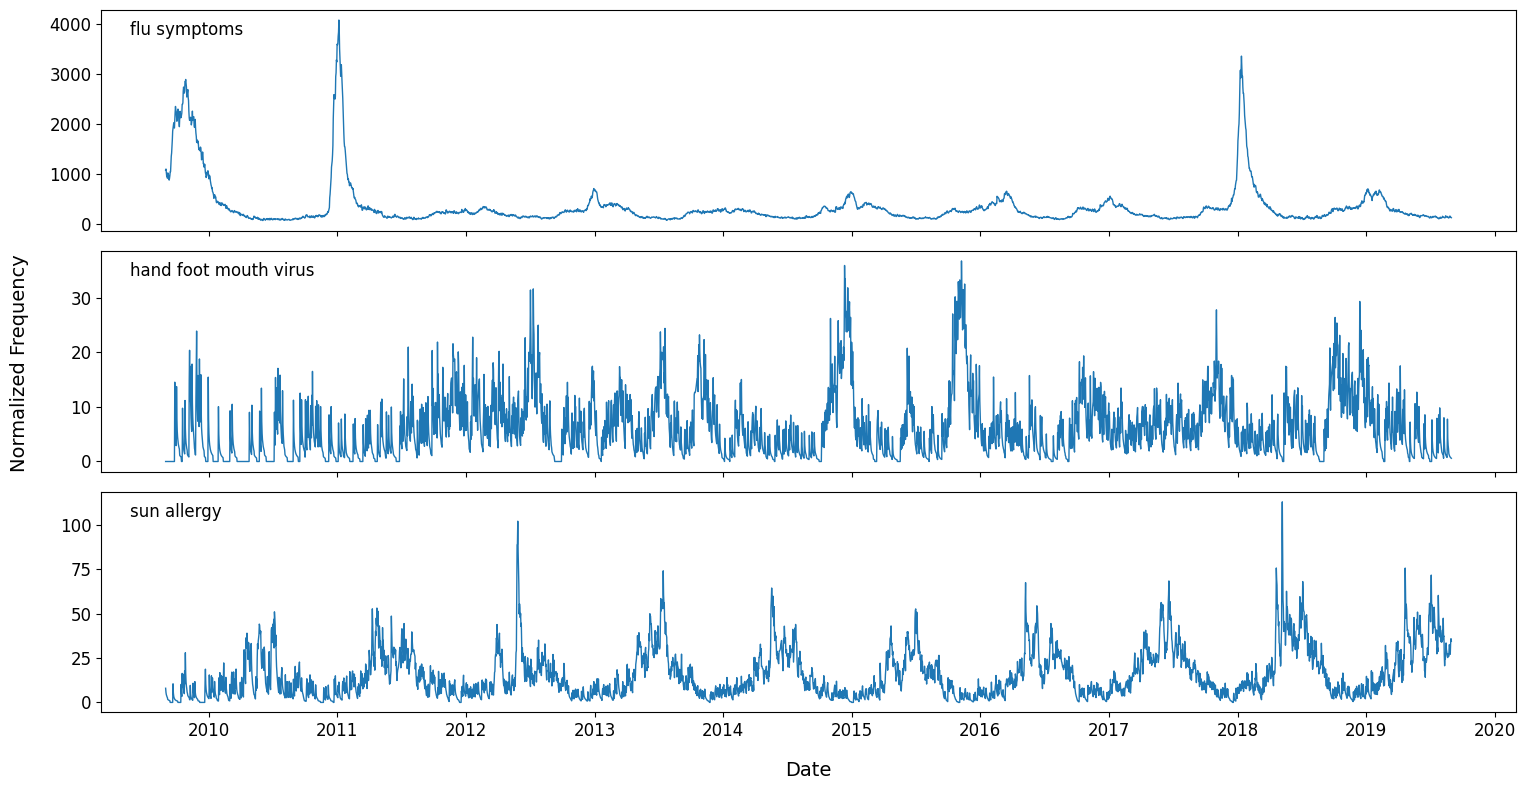

In [12]:
# Selected queries
high_corr_query = 'flu symptoms'
mid_corr_query = 'hand foot mouth virus'
low_corr_query = 'sun allergy'
selected_queries = [high_corr_query, mid_corr_query, low_corr_query]

final_df_scaled = final_df.copy()
query_columns = final_df_scaled[selected_queries]

# Normalize the query columns together using MinMaxScaler
scaler = MinMaxScaler()
query_columns_scaled = query_columns

# Create subplots for each selected query
fig, axs = plt.subplots(len(selected_queries), 1, figsize=(15, 8), sharex=True)

# Plot normalized search query frequencies for each selected query
for i, query in enumerate(selected_queries):
    ax = axs[i]
    ax.plot(final_df_scaled.index, query_columns_scaled.iloc[:, i], linestyle='-', color='tab:blue', alpha=1, linewidth=1)
    
    # Add query text to top left
    ax.text(0.02, 0.95, query, transform=ax.transAxes, fontsize=12, verticalalignment='top')

    # Increase font size of axis values
    ax.tick_params(axis='both', which='major', labelsize=12)

# Set x-axis label only for the last subplot
axs[-1].set_xlabel('Date', fontsize=14, labelpad=15)

# Set y-axis label in the middle of the figure
fig.text(-0.01, 0.54, 'Normalized Frequency', va='center', ha='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.savefig("graphs/search_query_trends_subplots.pdf", format="pdf", bbox_inches='tight')
plt.show()

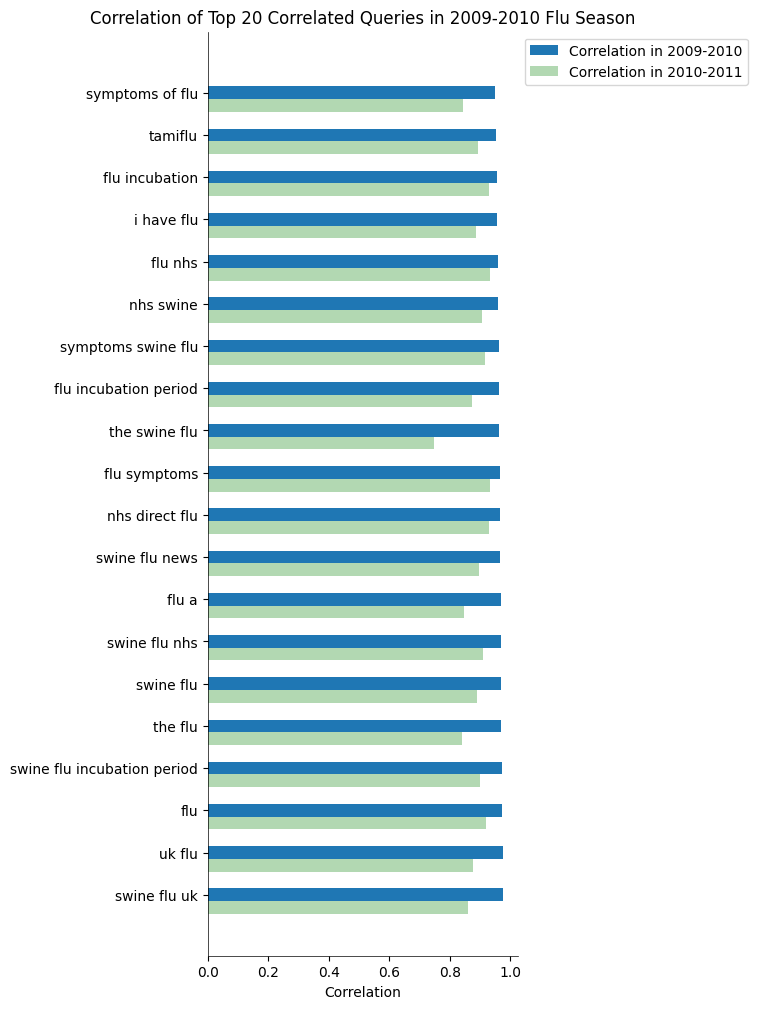

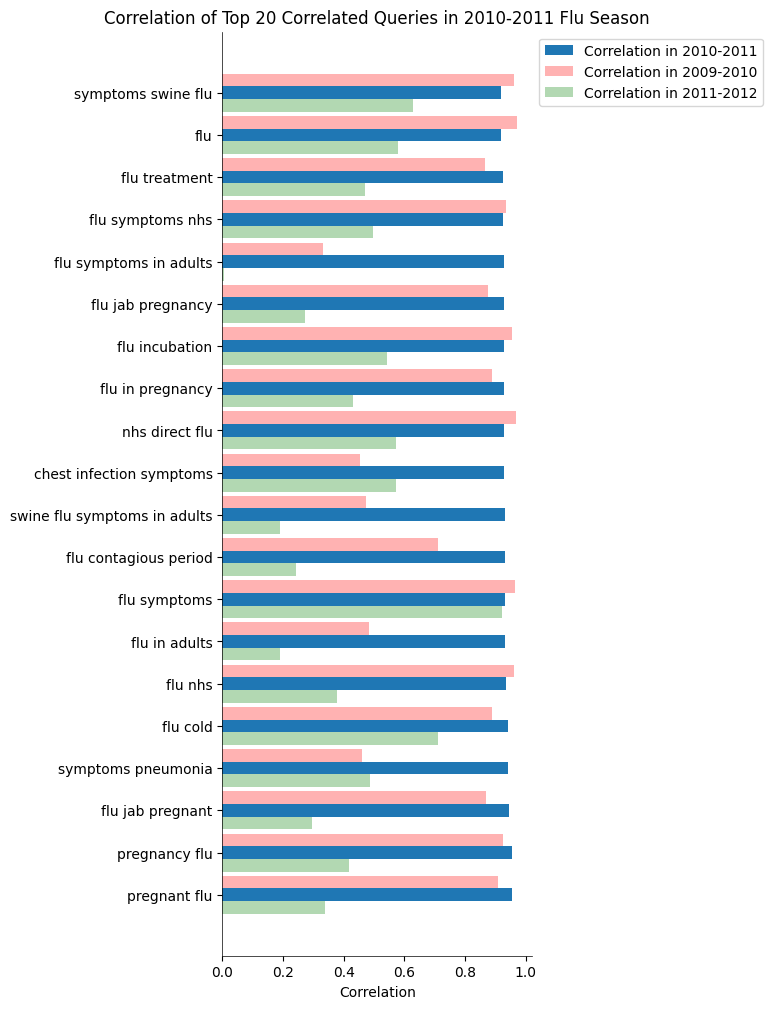

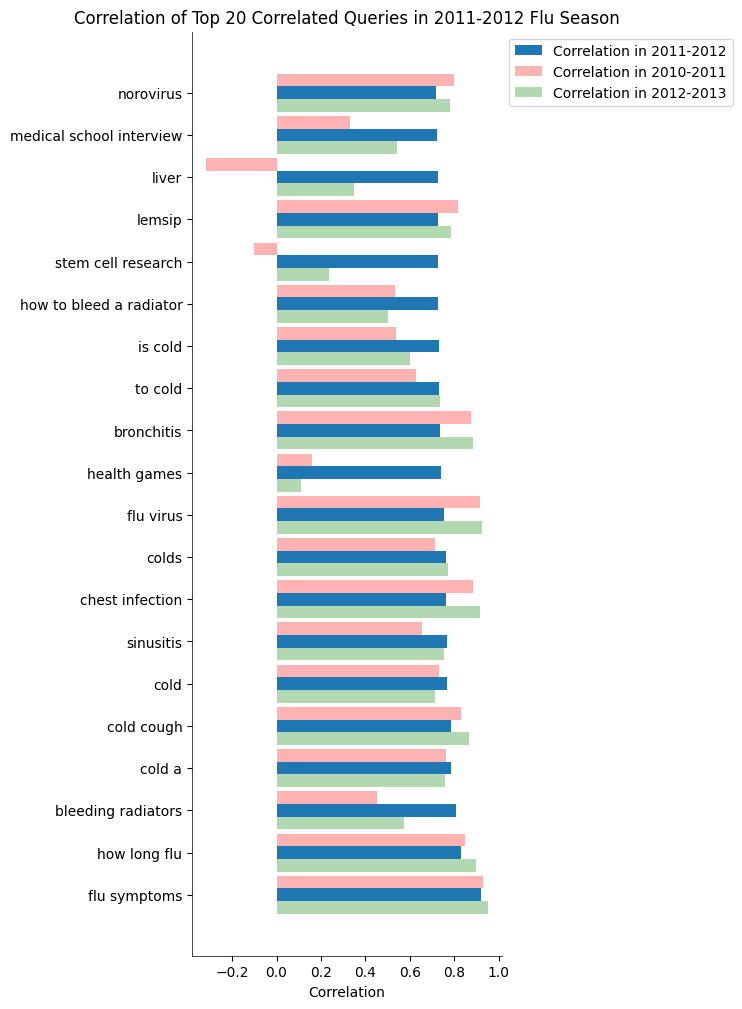

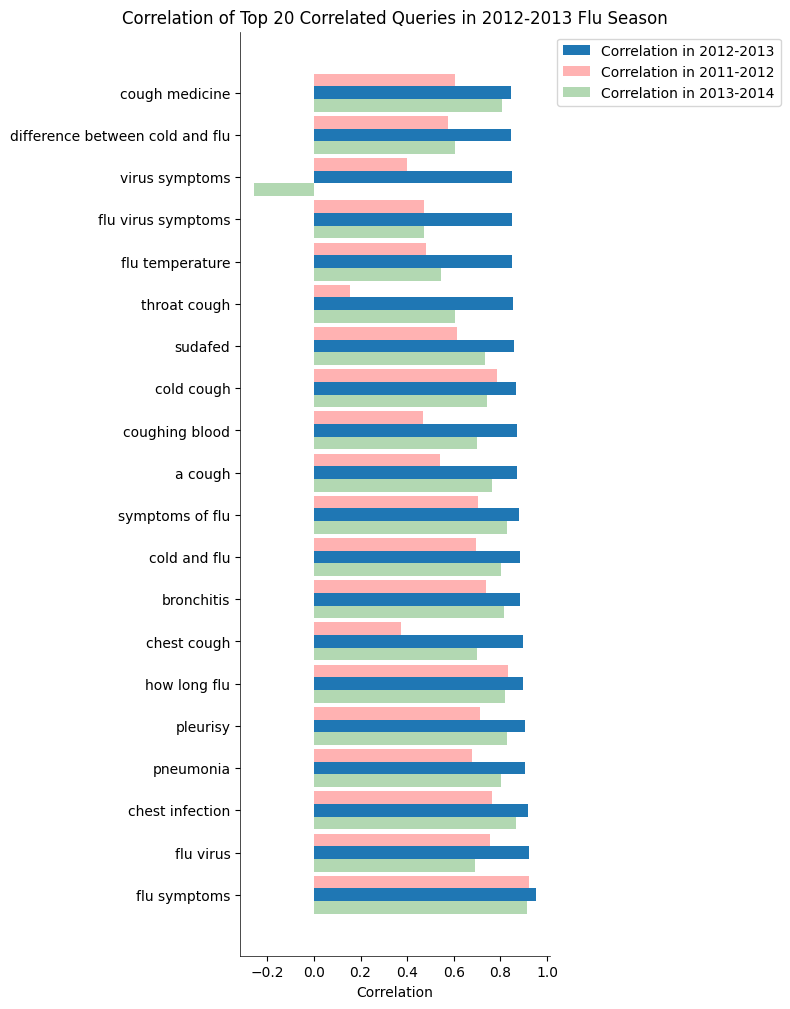

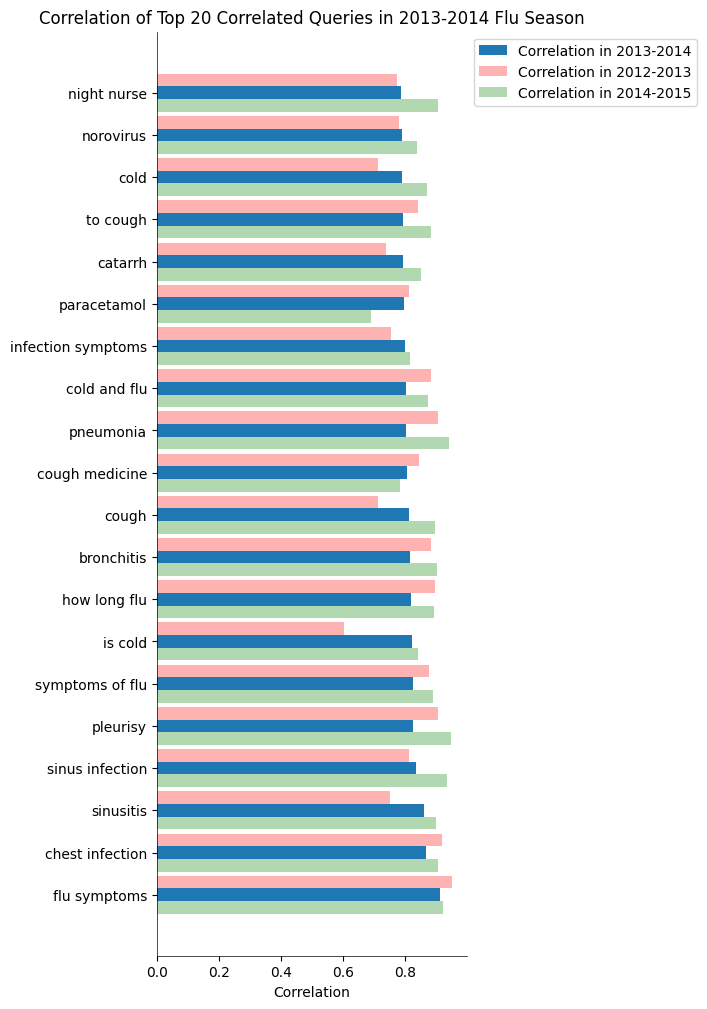

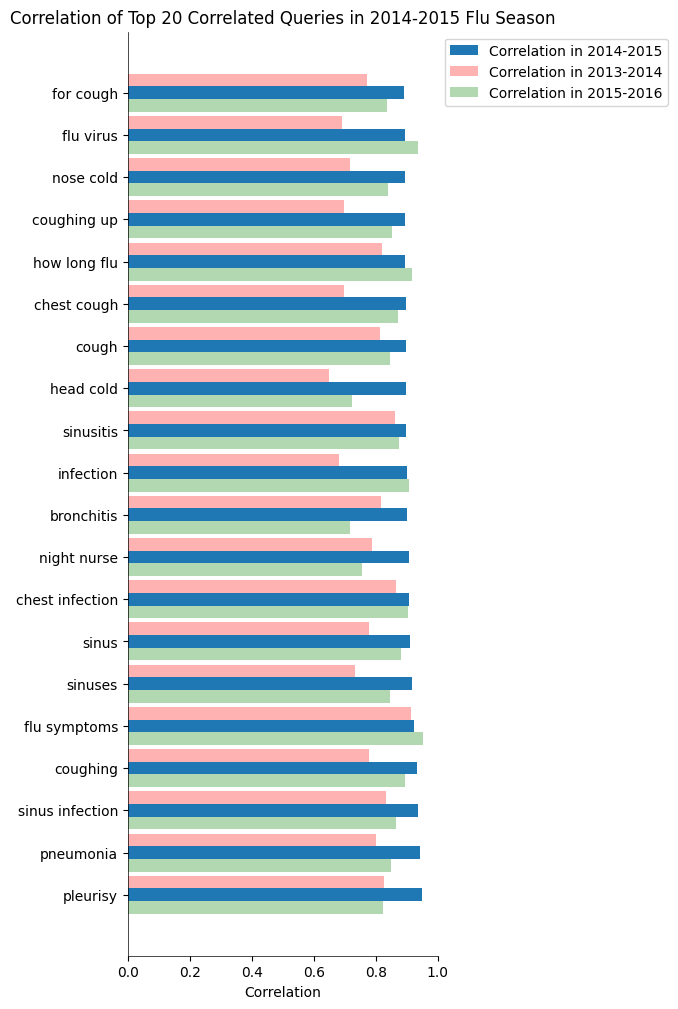

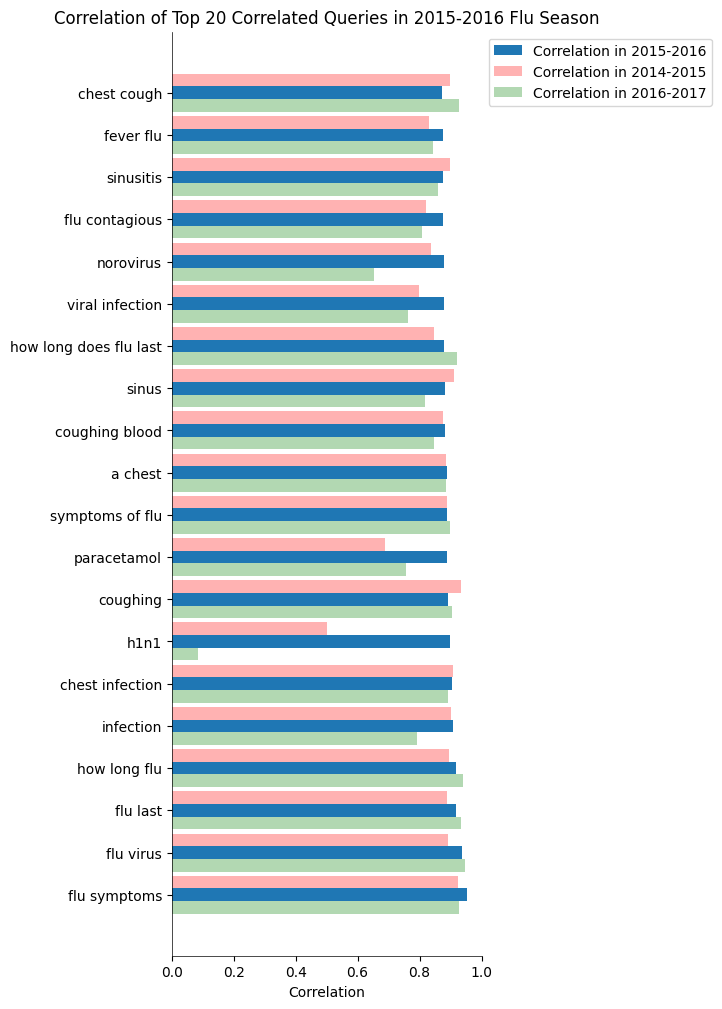

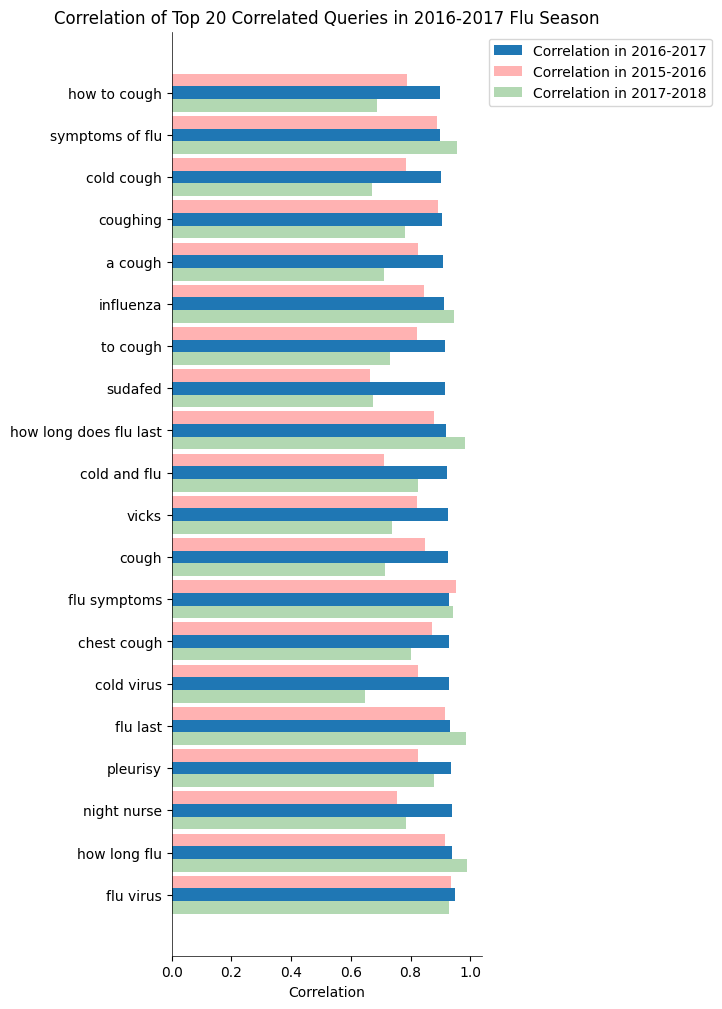

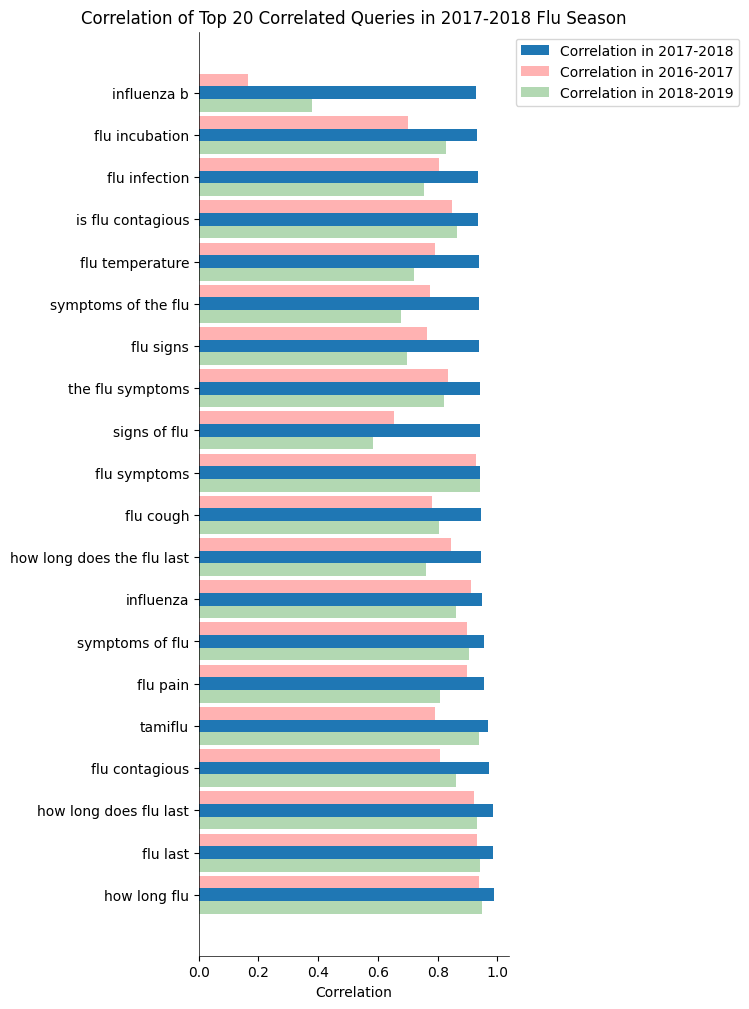

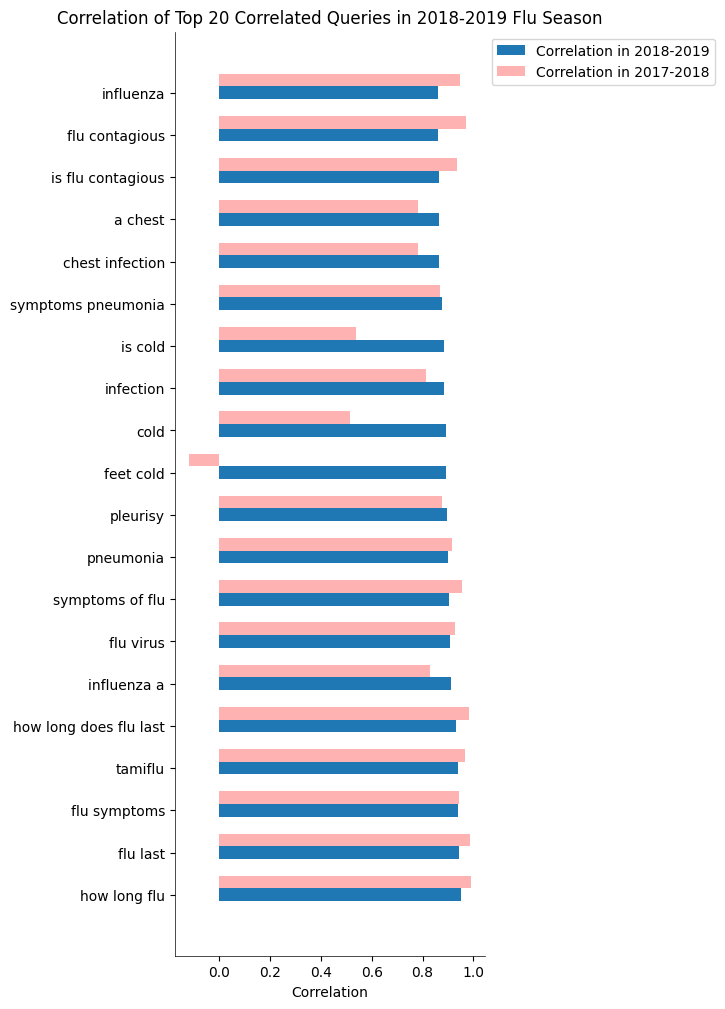

In [15]:
top_n = 20

season_top_queries = {}

for i, season in enumerate(seasons):
    season_top_queries[season] = {
        "top 20 corr": {},
        "prev corr": {},
        "next corr": {},
    }
    
    top_queries = dict(list(correlations_over_seasons[season].items())[:top_n])
    season_top_queries[season]["top 20 corr"] = top_queries 
    season_top_queries[season]["prev corr"] = {query: 0 for query in top_queries.keys()}
    season_top_queries[season]["next corr"] = {query: 0 for query in top_queries.keys()}

    if i > 0:
        prev_season_queries = correlations_over_seasons[seasons[i-1]]
        season_top_queries[season]["prev corr"] = {query: prev_season_queries[query] if query in prev_season_queries else 0 for query in top_queries.keys()}

    if i < len(seasons)-1:
        next_season_queries = correlations_over_seasons[seasons[i+1]]
        season_top_queries[season]["next corr"] = {query: next_season_queries[query] if query in next_season_queries else 0 for query in top_queries.keys()}

bar_positions = np.arange(top_n)

def get_label(season):
    start = season[0].split('-')[0]
    end = season[1].split('-')[0]
    return start + '-' + end

for i, season in enumerate(seasons):
    top_20_corr = season_top_queries[season]["top 20 corr"]
    prev_corr = season_top_queries[season]["prev corr"]
    next_corr = season_top_queries[season]["next corr"]

    fig, ax = plt.subplots(figsize=(4, 12))

    # Set the bar width for the current season
    bar_width = 0.3

    # Adjust the bar positions on the y-axis
    adjusted_positions_top_20 = bar_positions
    adjusted_positions_prev = bar_positions + bar_width
    adjusted_positions_next = bar_positions - bar_width

    # Plot the bars for each query using barh
    plt.barh(adjusted_positions_top_20, list(top_20_corr.values()), bar_width, color='tab:blue', label=f'Correlation in {get_label(season)}')
    plt.barh(adjusted_positions_prev, list(prev_corr.values()), bar_width, alpha=0.3, color='red', label=(f'Correlation in {get_label(seasons[i-1])}' if i > 0 else ''))
    plt.barh(adjusted_positions_next, list(next_corr.values()), bar_width, alpha=0.3, color='green', label=(f'Correlation in {get_label(seasons[i+1])}' if i < len(seasons)-1 else ''))

    plt.title(f'Correlation of Top 20 Correlated Queries in {get_label(season)} Flu Season')
    plt.xlabel('Correlation')
    plt.yticks(bar_positions, list(top_20_corr.keys()), fontsize=10)
    
    # Remove box outline and keep only x and y axes
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    plt.gca().spines['left'].set_linewidth(0.5)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.subplots_adjust(hspace=1)
    plt.savefig(f"graphs/query_correlations_{season}.pdf", format="pdf", bbox_inches='tight')
    plt.show()

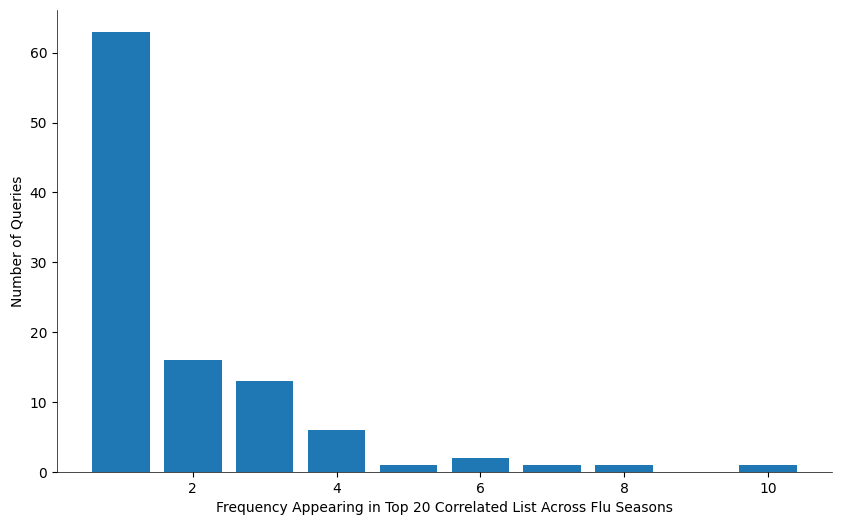

In [16]:
query_frequency = {}

for season in seasons:
    top_queries = season_top_queries[season]['top 20 corr']

    for query in top_queries.keys():
        query_frequency[query] = query_frequency.get(query, 0) + 1

# Count the number of queries for each frequency
frequency_counts = {}
for frequency in query_frequency.values():
    frequency_counts[frequency] = frequency_counts.get(frequency, 0) + 1

# Sort the frequency counts dictionary by frequency
sorted_frequency_counts = dict(sorted(frequency_counts.items()))

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_frequency_counts.keys(), sorted_frequency_counts.values(), color='tab:blue')
plt.xlabel('Frequency Appearing in Top 20 Correlated List Across Flu Seasons')
plt.ylabel('Number of Queries')
# plt.title('Distribution of Frequency of Queries Appearing in Top 20 Correlated List Across Flu Seasons')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)
plt.savefig(f"graphs/frequencies_of_top_correlated_queries.pdf", format="pdf", bbox_inches='tight')
plt.show()